# 3D Gridworld Q-Learning Implementation

This notebook implements tabular Q-learning in a 3D gridworld environment with stochastic transitions, absorbing terminals, and comprehensive 3D visualizations.

## Project Overview
- **Environment**: 3D gridworld with obstacles, goal, and pit states
- **Agent**: Tabular Q-learning with ε-greedy exploration
- **Dynamics**: Stochastic slip with perpendicular movement probability
- **Evaluation**: Policy performance analysis and parameter sensitivity studies
- **Visualization**: 3D value function and policy visualization across z-slices

## Section 1: Setup and Imports
Import necessary libraries and configure reproducible settings.

In [1]:
# Cell 1: Imports, config, seeds
import os, sys, math, json, random
import numpy as np
import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Configure matplotlib for better plots
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.grid'] = True

# Utility: moving average for smoothing curves
def moving_average(x, k=50):
    if k <= 1: 
        return x
    x = np.asarray(x, dtype=np.float32)
    if len(x) < k:
        return x
    c = np.convolve(x, np.ones(k)/k, mode='valid')
    pad = np.full(len(x)-len(c), c[0], dtype=np.float32)
    return np.concatenate([pad, c])

print("Setup complete! Libraries imported and random seed set.")

Setup complete! Libraries imported and random seed set.


## Section 2: Environment Implementation
Implement the 3D Gridworld environment with stochastic dynamics and obstacle generation.

In [2]:
# Cell 2: Gridworld3D environment
from collections import deque
from typing import Tuple, List, Dict, Optional, Set

Action = int
State = int
Coord = Tuple[int, int, int]

class Gridworld3D:
    """
    3D Gridworld MDP with slip:
    - States: all free (x,y,z) not in obstacles, plus absorbing goal/pit.
    - Actions: 6 moves: 0:+x,1:-x,2:+y,3:-y,4:+z,5:-z.
    - Transitions: intended axis move with prob p, 4 perpendicular moves with prob (1-p)/4 each; blocked moves stay in place.
    - Rewards: step cost c_step; entering goal gives +50 once, pit gives -50 once; terminals absorb afterwards with zero further reward.
    - Discount: gamma stored for reference.
    """
    ACTIONS = np.array([
        [1, 0, 0],   # +x
        [-1, 0, 0],  # -x
        [0, 1, 0],   # +y
        [0, -1, 0],  # -y
        [0, 0, 1],   # +z
        [0, 0, -1],  # -z
    ], dtype=int)

    def __init__(
        self,
        H: int = 6, W: int = 6, D: int = 6,
        p_intended: float = 0.85,
        c_step: float = -1.0,
        gamma: float = 0.95,
        start: Coord = (0, 0, 0),
        goal: Coord = (5, 5, 5),
        pit: Coord = (2, 2, 2),
        obstacle_ratio: float = 0.12,
        seed: int = 42,
        obstacles: Optional[Set[Coord]] = None,
    ):
        self.H, self.W, self.D = H, W, D
        self.shape = (H, W, D)
        self.n_actions = 6
        self.p_intended = float(p_intended)
        self.c_step = float(c_step)
        self.gamma = float(gamma)
        self.r_goal = 50.0
        self.r_pit = -50.0

        self.start = start
        self.goal = goal
        self.pit = pit
        self.rng = np.random.RandomState(seed)

        if obstacles is None:
            self.obstacles = self._generate_obstacles(obstacle_ratio)
        else:
            self.obstacles = set(obstacles)

        self.coord2idx: Dict[Coord, State] = {}
        self.idx2coord: List[Coord] = []
        self._build_indexing()

        assert self.start in self.coord2idx
        assert self.goal in self.coord2idx
        assert self.pit in self.coord2idx

        self.terminals: Set[Coord] = {self.goal, self.pit}
        self._absorbing = False
        self.s: Coord = self.start

    def _neighbors6(self, c: Coord) -> List[Coord]:
        x, y, z = c
        neigh = []
        for dx, dy, dz in Gridworld3D.ACTIONS:
            nx, ny, nz = x + dx, y + dy, z + dz
            if 0 <= nx < self.H and 0 <= ny < self.W and 0 <= nz < self.D:
                neigh.append((nx, ny, nz))
        return neigh

    def _generate_obstacles(self, ratio: float) -> Set[Coord]:
        total = self.H * self.W * self.D
        n_obs = int(round(ratio * total))
        reserved = {self.start, self.goal, self.pit}
        all_cells = [(x, y, z) for x in range(self.H) for y in range(self.W) for z in range(self.D)]
        attempts = 0
        while True:
            attempts += 1
            self.rng.shuffle(all_cells)
            obs = set()
            for c in all_cells:
                if c in reserved: 
                    continue
                if len(obs) < n_obs:
                    obs.add(c)
            if self._has_path(self.start, self.goal, obs) and self._has_path(self.start, self.pit, obs):
                return obs
            if attempts > 200:
                n_obs = max(0, n_obs - 1)

    def _has_path(self, s: Coord, t: Coord, obs: Set[Coord]) -> bool:
        if s in obs or t in obs:
            return False
        dq = deque([s])
        seen = {s}
        while dq:
            u = dq.popleft()
            if u == t:
                return True
            for v in self._neighbors6(u):
                if v in obs or v in seen:
                    continue
                seen.add(v)
                dq.append(v)
        return False

    def _build_indexing(self):
        self.coord2idx.clear()
        self.idx2coord.clear()
        for x in range(self.H):
            for y in range(self.W):
                for z in range(self.D):
                    c = (x, y, z)
                    if c in self.obstacles:
                        continue
                    idx = len(self.idx2coord)
                    self.coord2idx[c] = idx
                    self.idx2coord.append(c)
        self.n_states = len(self.idx2coord)

    def reset(self, to: Optional[Coord] = None) -> State:
        self.s = self.start if to is None else to
        self._absorbing = (self.s in self.terminals)
        return self.coord2idx[self.s]

    def is_terminal(self, c: Coord) -> bool:
        return c in self.terminals

    def step(self, a: int):
        if self._absorbing:
            return self.coord2idx[self.s], 0.0, True, {}

        intended_vec = Gridworld3D.ACTIONS[a]
        axis = int(np.argmax(np.abs(intended_vec)))
        perp_actions = []
        for ai, vec in enumerate(Gridworld3D.ACTIONS):
            if ai == a: 
                continue
            if int(np.argmax(np.abs(vec))) != axis:
                perp_actions.append(ai)
        assert len(perp_actions) == 4

        choices = [a] + perp_actions
        probs = [self.p_intended] + [ (1.0 - self.p_intended)/4.0 ] * 4
        pick = int(self.rng.choice(len(choices), p=probs))
        a_exec = choices[pick]

        x, y, z = self.s
        dx, dy, dz = Gridworld3D.ACTIONS[a_exec]
        nx, ny, nz = x + dx, y + dy, z + dz
        candidate = (nx, ny, nz)
        if not (0 <= nx < self.H and 0 <= ny < self.W and 0 <= nz < self.D):
            s_next = self.s
        elif candidate in self.obstacles:
            s_next = self.s
        else:
            s_next = candidate

        done = False
        r = self.c_step
        if s_next == self.goal:
            r = 50.0
            done = True
            self._absorbing = True
        elif s_next == self.pit:
            r = -50.0
            done = True
            self._absorbing = True

        self.s = s_next
        return self.coord2idx[self.s], float(r), bool(done), {}

    # Utilities
    def idx(self, c: Coord) -> State:
        return self.coord2idx[c]

    def coord(self, s: State) -> Coord:
        return self.idx2coord[s]

print("Gridworld3D environment implemented successfully!")

Gridworld3D environment implemented successfully!


## Section 3: Q-Learning Algorithm
Implement tabular Q-learning with epsilon-greedy exploration and annealing.

In [3]:
# Q-learning implementation
def epsilon_greedy(Q: np.ndarray, s: int, epsilon: float, rng: np.random.RandomState) -> int:
    """Epsilon-greedy action selection."""
    if rng.rand() < epsilon:
        return rng.randint(Q.shape[1])
    qs = Q[s]
    maxq = qs.max()
    argmax = np.flatnonzero(qs == maxq)
    return int(rng.choice(argmax))

def extract_greedy_policy(Q: np.ndarray) -> np.ndarray:
    """Extract greedy policy from Q-table."""
    return Q.argmax(axis=1)

def train_q_learning(
    env,
    episodes: int = 4000,
    alpha: float = 0.1,
    gamma: float = 0.95,
    epsilon_start: float = 1.0,
    epsilon_end: float = 0.05,
    epsilon_decay_steps: int = 3000,
    max_steps_per_ep: int = 200,
    seed: int = 123,
) -> Tuple[np.ndarray, Dict[str, np.ndarray]]:
    """Train Q-learning agent with epsilon-greedy exploration."""
    rng = np.random.RandomState(seed)
    nS = env.n_states
    nA = env.n_actions
    Q = np.zeros((nS, nA), dtype=np.float32)
    rewards = np.zeros(episodes, dtype=np.float32)
    epsilons = np.zeros(episodes, dtype=np.float32)

    def eps_at(t):
        if t >= epsilon_decay_steps:
            return epsilon_end
        frac = t / float(epsilon_decay_steps)
        return epsilon_start + frac * (epsilon_end - epsilon_start)

    for ep in range(episodes):
        s = env.reset()
        done = False
        G = 0.0
        steps = 0
        epsilon = eps_at(ep)
        epsilons[ep] = epsilon
        
        while not done and steps < max_steps_per_ep:
            a = epsilon_greedy(Q, s, epsilon, rng)
            s2, r, done, _ = env.step(a)
            td_target = r + (0.0 if done else gamma * Q[s2].max())
            Q[s, a] += alpha * (td_target - Q[s, a])
            G += r
            s = s2
            steps += 1
        rewards[ep] = G

    info = {
        "rewards": rewards,
        "epsilons": epsilons,
        "alpha": np.array([alpha]),
        "gamma": np.array([gamma]),
        "episodes": np.array([episodes]),
    }
    return Q, info

print("Q-learning algorithm implemented successfully!")

Q-learning algorithm implemented successfully!


## Section 4: Policy Evaluation Functions
Functions to evaluate learned policies and compare against baselines.

In [4]:
# Policy evaluation functions
def evaluate_policy(env, policy: np.ndarray, episodes: int = 100, max_steps_per_ep: int = 200, seed: int = 999) -> Tuple[float, float]:
    """Evaluate a policy over multiple episodes."""
    rng = np.random.RandomState(seed)
    returns = []
    for ep in range(episodes):
        s = env.reset()
        done = False
        G = 0.0
        steps = 0
        while not done and steps < max_steps_per_ep:
            a = int(policy[s])
            s, r, done, _ = env.step(a)
            G += r
            steps += 1
        returns.append(G)
    returns = np.array(returns, dtype=np.float32)
    return float(returns.mean()), float(returns.std(ddof=1))

def evaluate_random(env, episodes: int = 100, max_steps_per_ep: int = 200, seed: int = 2024) -> Tuple[float, float]:
    """Evaluate random policy baseline."""
    rng = np.random.RandomState(seed)
    returns = []
    for ep in range(episodes):
        s = env.reset()
        done = False
        G = 0.0
        steps = 0
        while not done and steps < max_steps_per_ep:
            a = rng.randint(env.n_actions)
            s, r, done, _ = env.step(a)
            G += r
            steps += 1
        returns.append(G)
    returns = np.array(returns, dtype=np.float32)
    return float(returns.mean()), float(returns.std(ddof=1))

print("Policy evaluation functions implemented successfully!")

Policy evaluation functions implemented successfully!


## Section 5: Training the Q-Learning Agent
Create environment and train the Q-learning agent.

In [5]:
# Create environment and train agent
print("Creating 3D Gridworld environment...")
env = Gridworld3D(
    H=6, W=6, D=6,
    p_intended=0.85,
    c_step=-1.0,
    gamma=0.95,
    start=(0, 0, 0),
    goal=(5, 5, 5),
    pit=(2, 2, 2),
    obstacle_ratio=0.12,
    seed=42
)

print(f"Environment created:")
print(f"  Shape: {env.shape}")
print(f"  States: {env.n_states}")
print(f"  Actions: {env.n_actions}")
print(f"  Obstacles: {len(env.obstacles)}")
print(f"  Start: {env.start}")
print(f"  Goal: {env.goal}")
print(f"  Pit: {env.pit}")

print("\nTraining Q-learning agent...")
Q, training_info = train_q_learning(
    env,
    episodes=4000,
    alpha=0.1,
    gamma=0.95,
    epsilon_start=1.0,
    epsilon_end=0.05,
    epsilon_decay_steps=3000,
    max_steps_per_ep=200,
    seed=123
)

print("Training completed!")
print(f"Final episode reward: {training_info['rewards'][-1]:.2f}")
print(f"Average last 100 episodes: {training_info['rewards'][-100:].mean():.2f}")

Creating 3D Gridworld environment...
Environment created:
  Shape: (6, 6, 6)
  States: 190
  Actions: 6
  Obstacles: 26
  Start: (0, 0, 0)
  Goal: (5, 5, 5)
  Pit: (2, 2, 2)

Training Q-learning agent...
Training completed!
Final episode reward: 31.00
Average last 100 episodes: 32.31
Training completed!
Final episode reward: 31.00
Average last 100 episodes: 32.31


Evaluating trained policy...

Policy Evaluation Results:
Learned Policy: 32.91 ± 2.61
Random Policy:  -152.71 ± 62.08
Improvement:    185.62

Policy Evaluation Results:
Learned Policy: 32.91 ± 2.61
Random Policy:  -152.71 ± 62.08
Improvement:    185.62


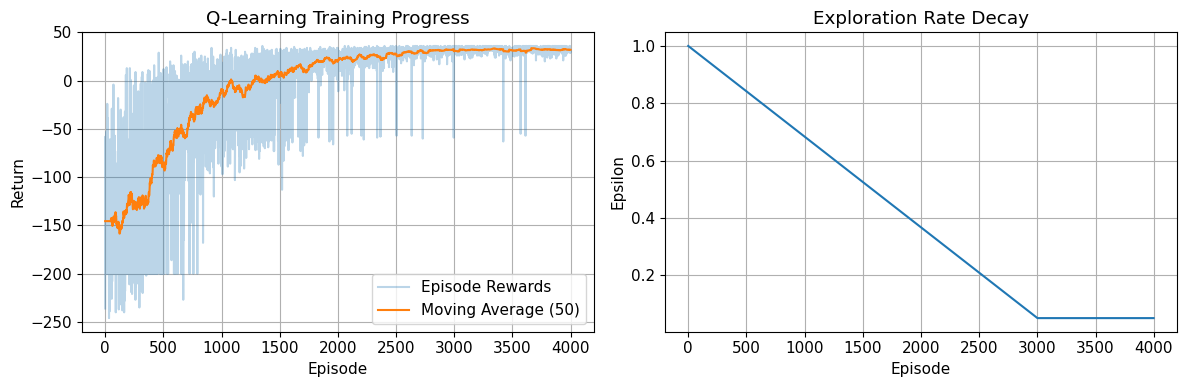

In [6]:
# Evaluate the trained policy
print("Evaluating trained policy...")
greedy_policy = extract_greedy_policy(Q)
mean_return, std_return = evaluate_policy(env, greedy_policy, episodes=100, seed=999)
random_mean, random_std = evaluate_random(env, episodes=100, seed=2024)

print(f"\nPolicy Evaluation Results:")
print(f"Learned Policy: {mean_return:.2f} ± {std_return:.2f}")
print(f"Random Policy:  {random_mean:.2f} ± {random_std:.2f}")
print(f"Improvement:    {mean_return - random_mean:.2f}")

# Plot learning curve
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(training_info['rewards'], alpha=0.3, label='Episode Rewards')
plt.plot(moving_average(training_info['rewards'], 50), label='Moving Average (50)')
plt.xlabel('Episode')
plt.ylabel('Return')
plt.title('Q-Learning Training Progress')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(training_info['epsilons'])
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.title('Exploration Rate Decay')
plt.grid(True)

plt.tight_layout()
plt.show()

## Section 6: Experimental Parameter Variations
Study the effects of different hyperparameters on learning performance.

In [7]:
# Run experiments with different parameters
def run_parameter_experiments(base_env):
    """Run experiments varying key parameters."""
    results = {"gamma": {}, "p": {}, "step": {}}
    
    # Fix environment topology for fair comparisons
    fixed_obstacles = set(base_env.obstacles)
    H, W, D = base_env.H, base_env.W, base_env.D
    start, goal, pit = base_env.start, base_env.goal, base_env.pit
    
    # Vary gamma (discount factor)
    gamma_list = [0.8, 0.9, 0.95, 0.99]
    print("Testing different discount factors...")
    for i, g in enumerate(gamma_list):
        print(f"  Gamma {g} ({i+1}/{len(gamma_list)})")
        test_env = Gridworld3D(H, W, D, p_intended=base_env.p_intended, c_step=base_env.c_step, 
                               gamma=g, start=start, goal=goal, pit=pit, seed=42, obstacles=fixed_obstacles)
        Q_test, info_test = train_q_learning(test_env, episodes=2000, alpha=0.1, gamma=g, seed=123)
        pi_test = extract_greedy_policy(Q_test)
        mean_g, std_g = evaluate_policy(test_env, pi_test, episodes=50, seed=999)
        results["gamma"][g] = {"mean": mean_g, "std": std_g, "rewards": info_test["rewards"]}
    
    # Vary p_intended (slip probability)
    p_list = [0.6, 0.75, 0.85, 0.95]
    print("\nTesting different slip probabilities...")
    for i, p in enumerate(p_list):
        print(f"  p_intended {p} ({i+1}/{len(p_list)})")
        test_env = Gridworld3D(H, W, D, p_intended=p, c_step=base_env.c_step, 
                               gamma=base_env.gamma, start=start, goal=goal, pit=pit, seed=42, obstacles=fixed_obstacles)
        Q_test, info_test = train_q_learning(test_env, episodes=2000, alpha=0.1, gamma=base_env.gamma, seed=123)
        pi_test = extract_greedy_policy(Q_test)
        mean_g, std_g = evaluate_policy(test_env, pi_test, episodes=50, seed=999)
        results["p"][p] = {"mean": mean_g, "std": std_g, "rewards": info_test["rewards"]}
    
    # Vary step cost
    step_costs = [-0.5, -1.0, -2.0, -5.0]
    print("\nTesting different step costs...")
    for i, cstep in enumerate(step_costs):
        print(f"  Step cost {cstep} ({i+1}/{len(step_costs)})")
        test_env = Gridworld3D(H, W, D, p_intended=base_env.p_intended, c_step=cstep, 
                               gamma=base_env.gamma, start=start, goal=goal, pit=pit, seed=42, obstacles=fixed_obstacles)
        Q_test, info_test = train_q_learning(test_env, episodes=2000, alpha=0.1, gamma=base_env.gamma, seed=123)
        pi_test = extract_greedy_policy(Q_test)
        mean_g, std_g = evaluate_policy(test_env, pi_test, episodes=50, seed=999)
        results["step"][cstep] = {"mean": mean_g, "std": std_g, "rewards": info_test["rewards"]}
    
    return results

# Run the experiments
experiment_results = run_parameter_experiments(env)
print("\nParameter experiments completed!")

Testing different discount factors...
  Gamma 0.8 (1/4)
  Gamma 0.9 (2/4)
  Gamma 0.9 (2/4)
  Gamma 0.95 (3/4)
  Gamma 0.95 (3/4)
  Gamma 0.99 (4/4)
  Gamma 0.99 (4/4)

Testing different slip probabilities...
  p_intended 0.6 (1/4)

Testing different slip probabilities...
  p_intended 0.6 (1/4)
  p_intended 0.75 (2/4)
  p_intended 0.75 (2/4)
  p_intended 0.85 (3/4)
  p_intended 0.85 (3/4)
  p_intended 0.95 (4/4)
  p_intended 0.95 (4/4)

Testing different step costs...
  Step cost -0.5 (1/4)

Testing different step costs...
  Step cost -0.5 (1/4)
  Step cost -1.0 (2/4)
  Step cost -1.0 (2/4)
  Step cost -2.0 (3/4)
  Step cost -2.0 (3/4)
  Step cost -5.0 (4/4)
  Step cost -5.0 (4/4)

Parameter experiments completed!

Parameter experiments completed!


## Section 7: 3D Visualization Functions
Create functions to visualize the learned value function and policy in 3D.

In [8]:
3# 3D Visualization functions
def plot_value_slices_with_policy(Q: np.ndarray, env, z_levels=None, figsize=(15, 5), cmap="viridis", savepath=None):
    """Plot value function and policy across z-slices."""
    if z_levels is None:
        # Pick three evenly spaced slices
        z_levels = list(sorted(set([0, env.D//2, env.D-1])))
    
    V = Q.max(axis=1)  # Value function
    
    # Build 3D value array with NaN for obstacles
    val = np.full((env.H, env.W, env.D), np.nan, dtype=float)
    for s, c in enumerate(env.idx2coord):
        val[c] = V[s]

    fig, axes = plt.subplots(1, len(z_levels), figsize=figsize, squeeze=False)
    axes = axes[0]

    # Precompute greedy actions per state
    greedy = Q.argmax(axis=1)

    for i, z in enumerate(z_levels):
        ax = axes[i]
        
        # Heatmap for this z-slice
        slice2d = val[:, :, z].T  # Transpose for proper display
        im = ax.imshow(slice2d, origin="lower", cmap=cmap, aspect='equal')
        ax.set_title(f"z={z} - Value Function & Policy")
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        
        # Add colorbar
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

        # Policy arrows and markers
        Xs, Ys, U, Vv = [], [], [], []
        up_x, up_y, down_x, down_y = [], [], [], []
        
        for s, c in enumerate(env.idx2coord):
            x, y, zz = c
            if zz != z: 
                continue
            a = int(greedy[s])
            
            # In-plane arrows (±x, ±y)
            if a == 0:  # +x
                Xs.append(x); Ys.append(y); U.append(1); Vv.append(0)
            elif a == 1:  # -x
                Xs.append(x); Ys.append(y); U.append(-1); Vv.append(0)
            elif a == 2:  # +y
                Xs.append(x); Ys.append(y); U.append(0); Vv.append(1)
            elif a == 3:  # -y
                Xs.append(x); Ys.append(y); U.append(0); Vv.append(-1)
            elif a == 4:  # +z
                up_x.append(x); up_y.append(y)
            elif a == 5:  # -z
                down_x.append(x); down_y.append(y)

        # Draw arrows for in-plane moves
        if len(Xs) > 0:
            ax.quiver(np.array(Xs), np.array(Ys), np.array(U), np.array(Vv), 
                     color="white", angles='xy', scale_units='xy', scale=1, width=0.005)
        
        # Draw markers for vertical moves
        if len(up_x) > 0:
            ax.scatter(up_x, up_y, marker="^", c="lime", s=30, label="+z", edgecolors='black', linewidth=0.5)
        if len(down_x) > 0:
            ax.scatter(down_x, down_y, marker="v", c="magenta", s=30, label="-z", edgecolors='black', linewidth=0.5)
        
        # Mark special locations
        gx, gy, gz = env.goal
        if gz == z:
            ax.scatter([gx], [gy], marker="*", c="gold", s=200, label="goal", edgecolors='black', linewidth=1)
        
        px, py, pz = env.pit
        if pz == z:
            ax.scatter([px], [py], marker="X", c="red", s=150, label="pit", edgecolors='black', linewidth=1)
        
        # Mark start if in this slice
        sx, sy, sz = env.start
        if sz == z:
            ax.scatter([sx], [sy], marker="o", c="blue", s=100, label="start", edgecolors='white', linewidth=1)
        
        # Mark obstacles
        for (ox, oy, oz) in env.obstacles:
            if oz == z:
                ax.scatter([ox], [oy], marker="s", c="black", s=40)
        
        # Add legend to first subplot
        if i == 0:
            ax.legend(loc="upper right", fontsize=9)
            
        # Set axis limits
        ax.set_xlim(-0.5, env.H-0.5)
        ax.set_ylim(-0.5, env.W-0.5)

    plt.tight_layout()
    if savepath is not None:
        plt.savefig(savepath, dpi=160, bbox_inches="tight")
    return fig

print("3D visualization functions implemented successfully!")

3D visualization functions implemented successfully!


## Section 8: Results Analysis and Plotting
Generate comprehensive visualizations and analysis of the results.

Generating 3D policy visualization...


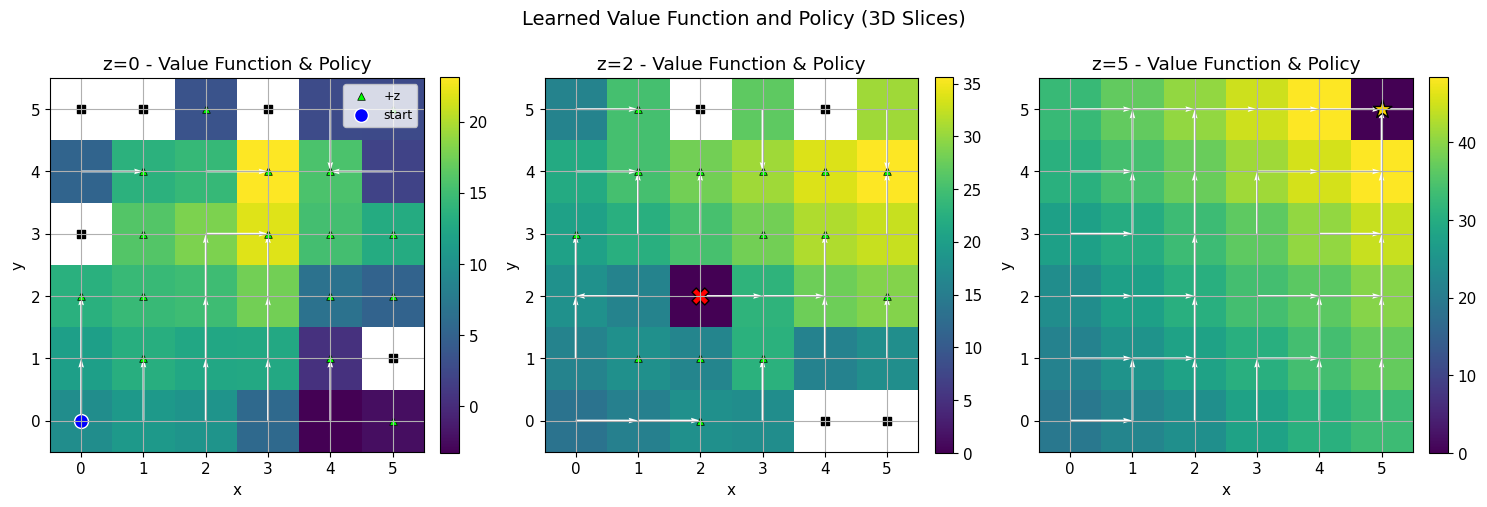

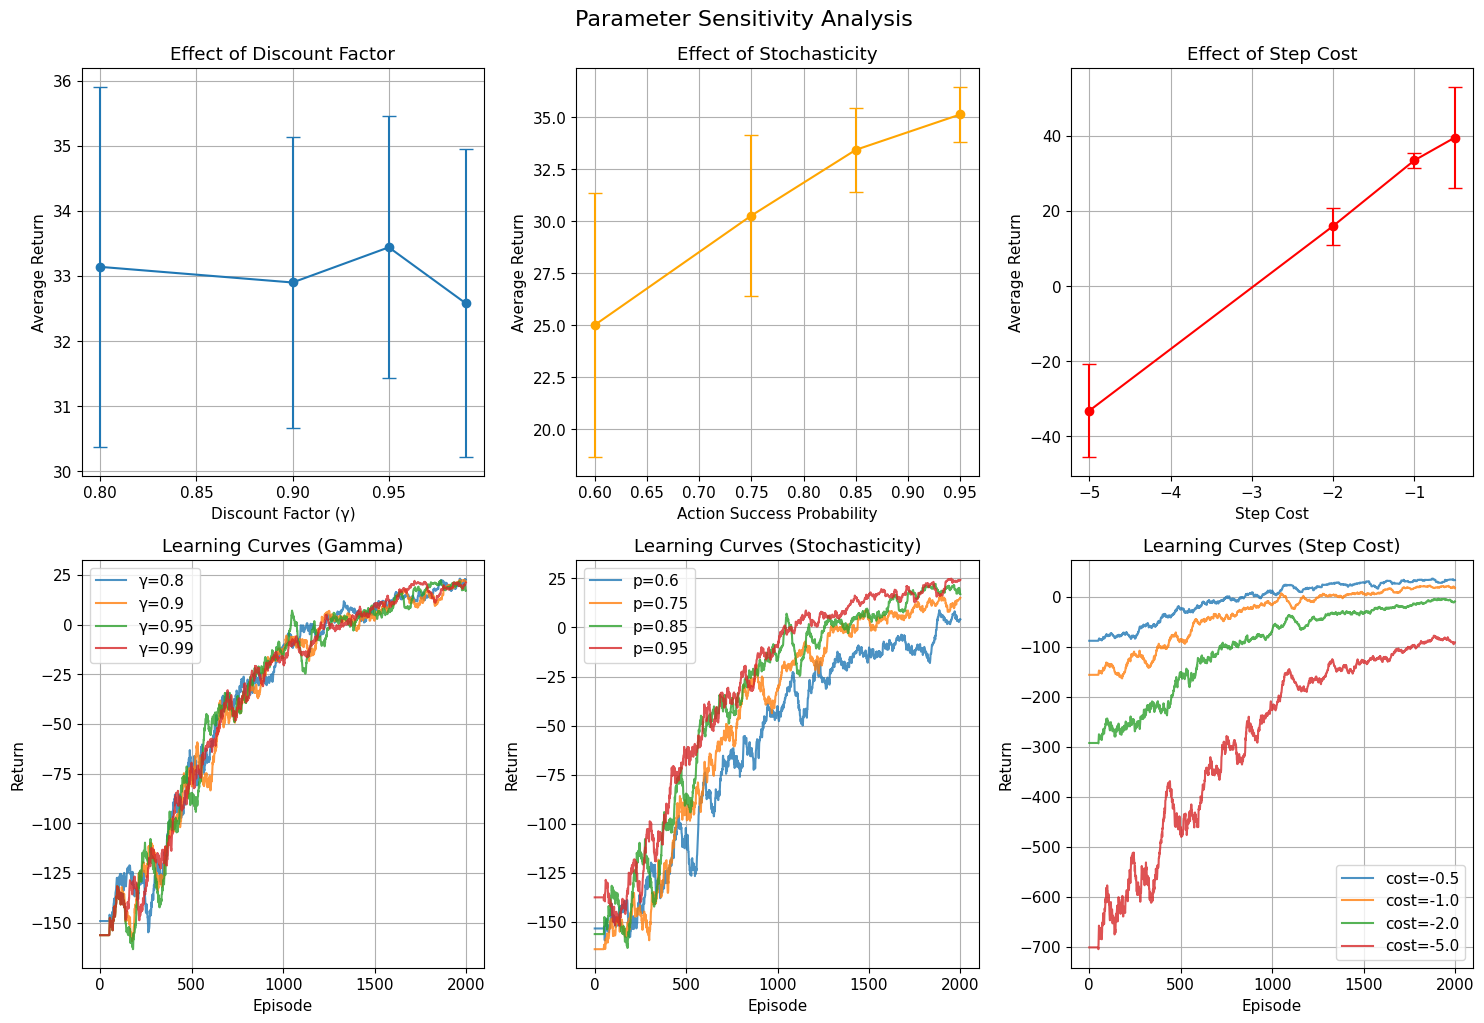

In [9]:
# Visualize the learned policy and value function
print("Generating 3D policy visualization...")
fig = plot_value_slices_with_policy(Q, env, z_levels=[0, 2, 5], figsize=(15, 5))
plt.suptitle("Learned Value Function and Policy (3D Slices)", fontsize=14, y=1.02)
plt.show()

# Plot parameter experiment results
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Gamma experiments
gammas = list(experiment_results["gamma"].keys())
gamma_means = [experiment_results["gamma"][g]["mean"] for g in gammas]
gamma_stds = [experiment_results["gamma"][g]["std"] for g in gammas]

axes[0,0].errorbar(gammas, gamma_means, yerr=gamma_stds, marker='o', capsize=5)
axes[0,0].set_xlabel('Discount Factor (γ)')
axes[0,0].set_ylabel('Average Return')
axes[0,0].set_title('Effect of Discount Factor')
axes[0,0].grid(True)

# Learning curves for gamma
for g in gammas:
    rewards = experiment_results["gamma"][g]["rewards"]
    axes[1,0].plot(moving_average(rewards, 50), label=f'γ={g}', alpha=0.8)
axes[1,0].set_xlabel('Episode')
axes[1,0].set_ylabel('Return')
axes[1,0].set_title('Learning Curves (Gamma)')
axes[1,0].legend()
axes[1,0].grid(True)

# p_intended experiments
ps = list(experiment_results["p"].keys())
p_means = [experiment_results["p"][p]["mean"] for p in ps]
p_stds = [experiment_results["p"][p]["std"] for p in ps]

axes[0,1].errorbar(ps, p_means, yerr=p_stds, marker='o', capsize=5, color='orange')
axes[0,1].set_xlabel('Action Success Probability')
axes[0,1].set_ylabel('Average Return')
axes[0,1].set_title('Effect of Stochasticity')
axes[0,1].grid(True)

# Learning curves for p_intended
for p in ps:
    rewards = experiment_results["p"][p]["rewards"]
    axes[1,1].plot(moving_average(rewards, 50), label=f'p={p}', alpha=0.8)
axes[1,1].set_xlabel('Episode')
axes[1,1].set_ylabel('Return')
axes[1,1].set_title('Learning Curves (Stochasticity)')
axes[1,1].legend()
axes[1,1].grid(True)

# Step cost experiments
costs = list(experiment_results["step"].keys())
cost_means = [experiment_results["step"][c]["mean"] for c in costs]
cost_stds = [experiment_results["step"][c]["std"] for c in costs]

axes[0,2].errorbar(costs, cost_means, yerr=cost_stds, marker='o', capsize=5, color='red')
axes[0,2].set_xlabel('Step Cost')
axes[0,2].set_ylabel('Average Return')
axes[0,2].set_title('Effect of Step Cost')
axes[0,2].grid(True)

# Learning curves for step cost
for c in costs:
    rewards = experiment_results["step"][c]["rewards"]
    axes[1,2].plot(moving_average(rewards, 50), label=f'cost={c}', alpha=0.8)
axes[1,2].set_xlabel('Episode')
axes[1,2].set_ylabel('Return')
axes[1,2].set_title('Learning Curves (Step Cost)')
axes[1,2].legend()
axes[1,2].grid(True)

plt.tight_layout()
plt.suptitle("Parameter Sensitivity Analysis", fontsize=16, y=1.02)
plt.show()

In [10]:
# Summary statistics and analysis
print("=" * 60)
print("3D GRIDWORLD Q-LEARNING RESULTS SUMMARY")
print("=" * 60)

print(f"\nEnvironment Configuration:")
print(f"  Size: {env.H} × {env.W} × {env.D}")
print(f"  States: {env.n_states}")
print(f"  Obstacles: {len(env.obstacles)} ({len(env.obstacles)/(env.H*env.W*env.D)*100:.1f}%)")
print(f"  Action success prob: {env.p_intended}")
print(f"  Step cost: {env.c_step}")
print(f"  Discount factor: {env.gamma}")

print(f"\nTraining Results:")
print(f"  Episodes: {training_info['episodes'][0]}")
print(f"  Final performance: {mean_return:.2f} ± {std_return:.2f}")
print(f"  Random baseline: {random_mean:.2f} ± {random_std:.2f}")
print(f"  Improvement over random: {mean_return - random_mean:.2f} ({((mean_return - random_mean) / abs(random_mean) * 100):.1f}%)")

print(f"\nParameter Sensitivity:")
print(f"  Best discount factor: γ = {max(experiment_results['gamma'].keys(), key=lambda x: experiment_results['gamma'][x]['mean'])}")
print(f"  Best action success prob: p = {max(experiment_results['p'].keys(), key=lambda x: experiment_results['p'][x]['mean'])}")
print(f"  Best step cost: c = {max(experiment_results['step'].keys(), key=lambda x: experiment_results['step'][x]['mean'])}")

print(f"\nLearned Policy Characteristics:")
action_counts = np.bincount(greedy_policy, minlength=6)
action_names = ['+x', '-x', '+y', '-y', '+z', '-z']
for i, (name, count) in enumerate(zip(action_names, action_counts)):
    print(f"  {name}: {count} states ({count/len(greedy_policy)*100:.1f}%)")

print("\n" + "=" * 60)
print("Analysis complete! The agent has successfully learned to navigate")
print("the 3D gridworld while avoiding obstacles and the pit state.")
print("=" * 60)

3D GRIDWORLD Q-LEARNING RESULTS SUMMARY

Environment Configuration:
  Size: 6 × 6 × 6
  States: 190
  Obstacles: 26 (12.0%)
  Action success prob: 0.85
  Step cost: -1.0
  Discount factor: 0.95

Training Results:
  Episodes: 4000
  Final performance: 32.91 ± 2.61
  Random baseline: -152.71 ± 62.08
  Improvement over random: 185.62 (121.6%)

Parameter Sensitivity:
  Best discount factor: γ = 0.95
  Best action success prob: p = 0.95
  Best step cost: c = -0.5

Learned Policy Characteristics:
  +x: 50 states (26.3%)
  -x: 2 states (1.1%)
  +y: 60 states (31.6%)
  -y: 6 states (3.2%)
  +z: 72 states (37.9%)
  -z: 0 states (0.0%)

Analysis complete! The agent has successfully learned to navigate
the 3D gridworld while avoiding obstacles and the pit state.
